In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# main variables

tickers= ['AAPL','MSFT','GOOG','AMZN','TSLA','NVDA']
period= "5y"
#number of simulations
num_sim = 10000

In [3]:
# Data Collection

def get_data(tickers, period):
    print(f"Downloading data for: {tickers}...")
    data= yf.download(tickers, period= period, auto_adjust= "True")["Close"]
    df_main =data.dropna()
    return df_main

In [4]:
# Analysis Part

def run_simulation(df):
    #log returns for time additivity
    log_returns= np.log(df/df.shift(1).dropna())

    #anuallise statistics
    trade_days= 252
    mean_returns= log_returns.mean()*trade_days
    cov_matrix= log_returns.cov()*trade_days

    # monte carlo simulations
    num_assets= len(df.columns)

    #initialise array 
    all_weights = np.zeros((num_sim, num_assets))
    ret_arr = np.zeros(num_sim)
    vol_arr = np.zeros(num_sim)
    sharpe_arr = np.zeros(num_sim)
    print (f"Simulating{num_sim} portfolio combinations...")

    for i in range (num_sim):
        #  random weight generation
        weights =np.random.random(num_assets)
        weights= weights/np.sum(weights)
        # for normalisation, sum= 1(100%)
        all_weights[i,:]= weights

        # portfolio returns
        ret_arr[i]= np.sum(mean_returns*weights)
        # calculate volatility (Std. Deviation)
        vol_arr[i]= np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        # calculate Sharpe Ratio, assume Risk free ratio - 0
        sharpe_arr[i]= ret_arr[i]/ vol_arr[i]

    return all_weights, ret_arr, vol_arr, sharpe_arr

In [5]:
# Execution

if __name__== "__main__":
    try:
        prices= pd.read_csv("stock_prices.csv", parse_dates= True, index_col="Date")
        print("Loaded data from local.csv")
    except FileNotFoundError:
        prices= get_data(tickers, period)
        prices.to_csv("stock_prices.csv")
        print("Data downloaded and saved to CSV.")

weights, returns, volatility, sharpe_ratios = run_simulation(prices)

# optimal Portfolio
max_sharpe_idx= sharpe_ratios.argmax()
max_sr_ret= returns[max_sharpe_idx]
max_sr_vol= volatility[max_sharpe_idx]
max_sr_sharpe= sharpe_ratios[max_sharpe_idx]

print("\n"+ "="*40)
print("Optimal Portfolio Allocation")
print("="*40)
print(f"{'ticker':<10}{'Allocation':>10}")
print("-"*25)

optimal_weights= weights[max_sharpe_idx,:]
for i, ticker in enumerate(prices.columns):
    print(f"{ticker:<10}{optimal_weights[i]:.2%}")

print("-"*25)
print(f"Expected Return: {max_sr_ret:.2%}")
print(f"Annual Risk: {max_sr_vol:.2%}")
print(f"Sharpe Ratio: {max_sr_sharpe:.2%}")
print("="*40)

Loaded data from local.csv
Simulating10000 portfolio combinations...

Optimal Portfolio Allocation
ticker    Allocation
-------------------------
AAPL      7.05%
AMZN      3.21%
GOOG      51.63%
MSFT      3.42%
NVDA      34.53%
TSLA      0.16%
-------------------------
Expected Return: 33.70%
Annual Risk: 32.38%
Sharpe Ratio: 104.07%


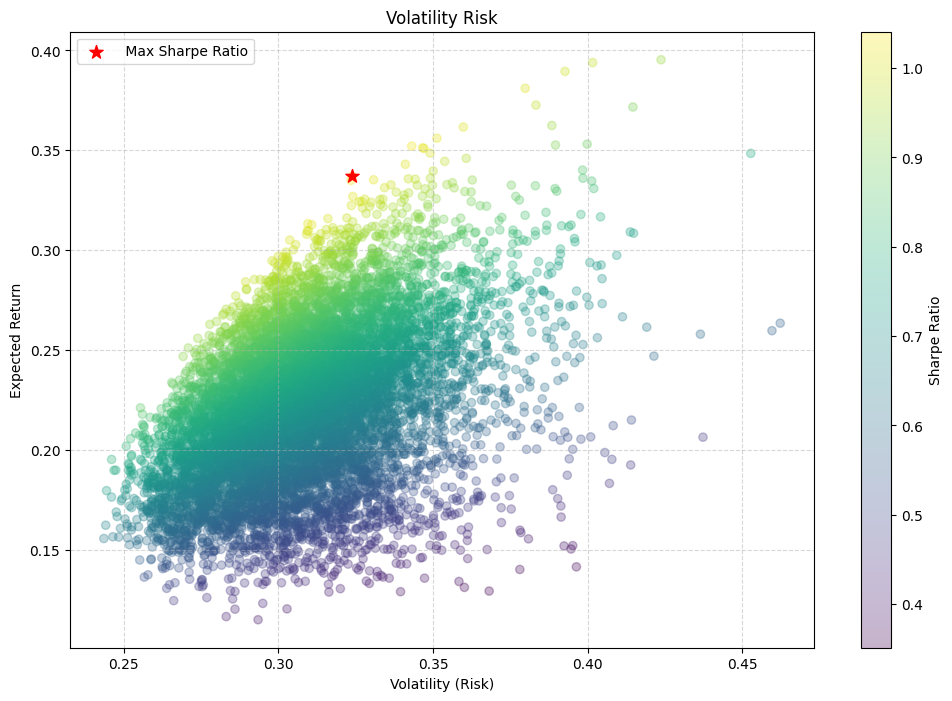

In [10]:
# Visualisation

plt.figure(figsize=(12,8))
plt.scatter(volatility, returns, c= sharpe_ratios, cmap='viridis', alpha=0.3)
plt.colorbar(label="Sharpe Ratio")

#marking the optimal portfolio with red star
plt.scatter(max_sr_vol, max_sr_ret, c="red", s=100, marker='*', label= ' Max Sharpe Ratio')
plt.title("Volatility Risk")
plt.ylabel("Expected Return")
plt.xlabel("Volatility (Risk)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
